# Early stopping in Gradient Boosting

Early stopping is a technique in Gradient Boosting that allows us to find the optimal number of iterations required to build a model that generalizes well to unseen data and avoids overfitting. The concept is simple: we set aside a portion of our dataset as a validation set (specified using validation_fraction) to assess the model’s performance during training. As the model is iteratively built with additional stages (trees), its performance on the validation set is monitored as a function of the number of steps.

Early stopping becomes effective when the model’s performance on the validation set plateaus or worsens (within deviations specified by tol) over a certain number of consecutive stages (specified by n_iter_no_change). This signals that the model has reached a point where further iterations may lead to overfitting, and it’s time to stop training.

The number of estimators (trees) in the final model, when early stopping is applied, can be accessed using the n_estimators_ attribute. Overall, early stopping is a valuable tool to strike a balance between model performance and efficiency in gradient boosting.


# 1. Load the dataset

In [99]:
import time

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

data = fetch_california_housing()
X, y = data.data[:600], data.target[:600]

In [101]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [104]:
pd.DataFrame(y).head()

,0
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [105]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
X_train.shape , X_val.shape

((480, 8), (120, 8))

# 2. Model Training and Comparison

Two GradientBoostingRegressor models are trained: one with and another without early stopping. The purpose is to compare their performance. It also calculates the training time and the n_estimators_ used by both models.

In [108]:
params = dict(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=42)

gbm_full = GradientBoostingRegressor(**params)
gbm_early_stopping = GradientBoostingRegressor(
    **params,
    validation_fraction=0.1,
    n_iter_no_change=10,
)

start_time = time.time()
gbm_full.fit(X_train, y_train)
training_time_full = time.time() - start_time
n_estimators_full = gbm_full.n_estimators_

start_time = time.time()
gbm_early_stopping.fit(X_train, y_train)
training_time_early_stopping = time.time() - start_time
estimators_early_stopping = gbm_early_stopping.n_estimators_

In [109]:
print(f"Training time with early stopping: {training_time_early_stopping:.2f} seconds")
print(f"Training time without early stopping: {training_time_full:.2f} seconds")
print(f"Number of estimators with early stopping: {estimators_early_stopping}")
print(f"Number of estimators without early stopping: {n_estimators_full}")

Training time with early stopping: 0.50 seconds
Training time without early stopping: 5.06 seconds
Number of estimators with early stopping: 119
Number of estimators without early stopping: 1000


# 3. Error Calculation

The code calculates the mean_squared_error for both training and validation datasets for the models trained in the previous section. It computes the errors for each boosting iteration. The purpose is to assess the performance and convergence of the models.

In [110]:
train_errors_without = []
val_errors_without = []

train_errors_with = []
val_errors_with = []

for i, (train_pred, val_pred) in enumerate(
    zip(
        gbm_full.staged_predict(X_train),
        gbm_full.staged_predict(X_val),
    )
):
    train_errors_without.append(mean_squared_error(y_train, train_pred))
    val_errors_without.append(mean_squared_error(y_val, val_pred))

for i, (train_pred, val_pred) in enumerate(
    zip(
        gbm_early_stopping.staged_predict(X_train),
        gbm_early_stopping.staged_predict(X_val),
    )
):
    train_errors_with.append(mean_squared_error(y_train, train_pred))
    val_errors_with.append(mean_squared_error(y_val, val_pred))

# 4. Visualize Comparison

It includes three subplots:

Plotting training errors of both models over boosting iterations.

Plotting validation errors of both models over boosting iterations.

Creating a bar chart to compare the training times and the estimator used of the models with and without early stopping.

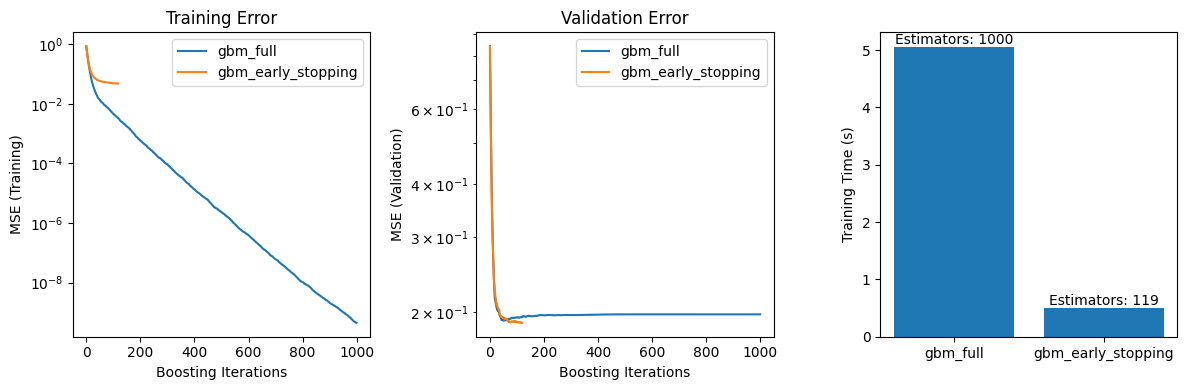

In [115]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

axes[0].plot(train_errors_without, label="gbm_full")
axes[0].plot(train_errors_with, label="gbm_early_stopping")
axes[0].set_xlabel("Boosting Iterations")
axes[0].set_ylabel("MSE (Training)")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].set_title("Training Error")

axes[1].plot(val_errors_without, label="gbm_full")
axes[1].plot(val_errors_with, label="gbm_early_stopping")
axes[1].set_xlabel("Boosting Iterations")
axes[1].set_ylabel("MSE (Validation)")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Validation Error")

training_times = [training_time_full, training_time_early_stopping]
labels = ["gbm_full", "gbm_early_stopping"]
bars = axes[2].bar(labels, training_times)
axes[2].set_ylabel("Training Time (s)")

for bar, n_estimators in zip(bars, [n_estimators_full, estimators_early_stopping]):
    height = bar.get_height()
    axes[2].text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.001,
        f"Estimators: {n_estimators}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

Conclusion

Preventing Overfitting: We showed how the validation error stabilizes or starts to increase after a certain point, indicating that the model generalizes better to unseen data. This is achieved by stopping the training
process before overfitting occurs.

Improving Training Efficiency: We compared training times between models with and without early stopping. The model with early stopping achieved comparable accuracy while requiring significantly fewer estimators, resulting in
faster training.